# Part II: Investigating the Vanishing Gradient Problem [20 pts]
Experimentally demonstrate the vanishing gradient problem in deep CNNs and understand how ResNet's architecture mitigates it. You will also explore other key CNN concepts through additional experiments.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import random
import zipfile
import os

In [ ]:
dataset_path = "cnn_dataset"

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root = dataset_path, transform = transform)
num_classes = len(dataset.classes)
num_images = len(dataset)
class_names = dataset.classes
class_distribution = {cls: 0 for cls in class_names}
class_sums = {cls: torch.zeros((3, 96, 96)) for cls in class_names}


for img, label in dataset:
    class_distribution[class_names[label]] += 1
    class_sums[class_names[label]] += img

dataset_stats = pd.DataFrame({
    "Category": list(class_distribution.keys()),
    "Image Count": list(class_distribution.values())
})

print(dataset_stats)

print("classes:", class_names)


   Category  Image Count
0      dogs        10000
1      food        10000
2  vehicles        10000
classes: ['dogs', 'food', 'vehicles']


In [ ]:
def create_one_hot_dataset(original_dataset, num_classes):
    images = []
    one_hot_labels = []

    for img, label in original_dataset:
        images.append(img)
        label_long = torch.tensor(label, dtype=torch.long)
        one_hot = F.one_hot(label_long, num_classes=num_classes)
        one_hot_labels.append(one_hot)

    images_tensor = torch.stack(images)
    labels_tensor = torch.stack(one_hot_labels)

    return TensorDataset(images_tensor, labels_tensor)


dataset = create_one_hot_dataset(dataset, num_classes=num_classes)

In [ ]:

indices = list(range(len(dataset)))
train_indices, temp_indices = train_test_split(indices, test_size = 0.30, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size = 0.50, random_state=42)

train_dataset = Subset(dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=64,shuffle=False, num_workers=4)
test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 21000
Validation set size: 4500
Test set size: 4500


Below is our Base model of VGG-16 network we developed in Part 1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class VGG16C(nn.Module):
    def __init__(self, num_classes = 3, init_type='xavier'):
        super(VGG16C, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.flatten_size = self.get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

        self.initialize_weights(init_type)

    def initialize_weights(self, init_type='xavier'):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if init_type.lower() == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                elif init_type.lower() == 'he':
                    nn.init.kaiming_normal_(m.weight, nonlinearity = 'relu')
                else:
                    pass
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 96, 96)
            output = self.features(dummy_input)

            return output.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


learning_rate = 0.003
optimizers = {
    'SGD': lambda params: optim.SGD(params, lr = learning_rate, momentum=0.9, weight_decay = 1e-4),
    'Adam': lambda params: optim.Adam(params, lr = learning_rate, weight_decay = 1e-4),
    'AdamW': lambda params: optim.AdamW(params, lr = learning_rate, weight_decay = 1e-4),
    'RMSprop': lambda params: optim.RMSprop(params, lr = learning_rate, weight_decay =1e-4),
}



Using device: cuda


## Step 1: Create a deeper version of your VGG-16 network (VGG-Deep)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class VGGDeep(nn.Module):
    def __init__(self, num_classes=3, init_type='xavier'):
        super(VGGDeep, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 6: Four additional convolutional layers
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.flatten_size = self.get_flatten_size()
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self.initialize_weights(init_type)

    def initialize_weights(self, init_type='xavier'):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if init_type.lower() == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                elif init_type.lower() == 'he':
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 96, 96)
            output = self.features(dummy_input)
            return output.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

learning_rate = 0.003
optimizer = optim.SGD(VGGDeep(num_classes=3).parameters(), lr=learning_rate, weight_decay=1e-4)



Using device: cuda


## Step 2: Training VGG-Deep

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_deep = VGGDeep(num_classes=3)
model_deep.to(device)

# Simple SGD with no momentum
optimizer_deep = optim.SGD(model_deep.parameters(), lr=learning_rate, weight_decay=1e-4)

scheduler_deep = None


Using device: cuda


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        labels = labels.argmax(dim=1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10, patience=3):
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        if scheduler is not None:
            scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch + 1} of {num_epochs}]: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model, history
register_hooks(model_deep)
model_deep, history_deep = train_model(
    model_deep,
    train_loader,
    val_loader,
    optimizer_deep,
    scheduler=scheduler_deep,
    num_epochs=10,
    patience=3
)



Epoch [1 of 10]: Train Loss: 1.0985, Train Acc: 0.3467 | Val Loss: 1.0985, Val Acc: 0.3309
Epoch [2 of 10]: Train Loss: 1.0983, Train Acc: 0.3503 | Val Loss: 1.0983, Val Acc: 0.3329
Epoch [3 of 10]: Train Loss: 1.0981, Train Acc: 0.3770 | Val Loss: 1.0979, Val Acc: 0.3329
Epoch [4 of 10]: Train Loss: 1.0976, Train Acc: 0.3970 | Val Loss: 1.0972, Val Acc: 0.3880
Epoch [5 of 10]: Train Loss: 1.0968, Train Acc: 0.5015 | Val Loss: 1.0964, Val Acc: 0.5684
Epoch [6 of 10]: Train Loss: 1.0955, Train Acc: 0.5822 | Val Loss: 1.0944, Val Acc: 0.6156
Epoch [7 of 10]: Train Loss: 1.0929, Train Acc: 0.6055 | Val Loss: 1.0916, Val Acc: 0.5556
Epoch [8 of 10]: Train Loss: 1.0882, Train Acc: 0.6007 | Val Loss: 1.0866, Val Acc: 0.5493
Epoch [9 of 10]: Train Loss: 1.0790, Train Acc: 0.5973 | Val Loss: 1.0709, Val Acc: 0.6169
Epoch [10 of 10]: Train Loss: 1.0600, Train Acc: 0.5995 | Val Loss: 1.0424, Val Acc: 0.6167


<span style='color:green'>The model’s training loss and train accuracy does improve somewhat steadily , so the model is learning something. The validation loss and accuracy actually fluctuates heavily.This erratic behavior is probably because vanishing gradients, possibly the model’s deeper layers are not receiving stable gradient flows. The big gaps between the training acurracy and validation accuracy at epoch 10 indicates that the model genralizes poorly. </span>

## Step 3: Gradient analysis

- Track the average L2 norm of the gradients in each convolutional layer using PyTorch hooks.

In [ ]:
from collections import defaultdict
grad_norms = defaultdict(list)

param2name_map = {}

def register_hooks(model):

    for idx, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d):
            layer_name = f"conv_layer_{idx}"
            param2name_map[layer.weight] = layer_name

            def make_param_hook(param):
                def hook_fn(grad):
                    grad_norm = grad.norm(p=2).item()
                    grad_norms[param2name_map[param]].append(grad_norm)
                return hook_fn
            layer.weight.register_hook(make_param_hook(layer.weight))

We are using "layer.weight.register_hook(make_param_hook(layer.weight))" because since we have used nn.Relu(inplace = "true") in all our layers for VGGDeep model architecture , it raised an error saying "BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients."


- Create a plot showing the average gradient norm for each convolutional layer over time.

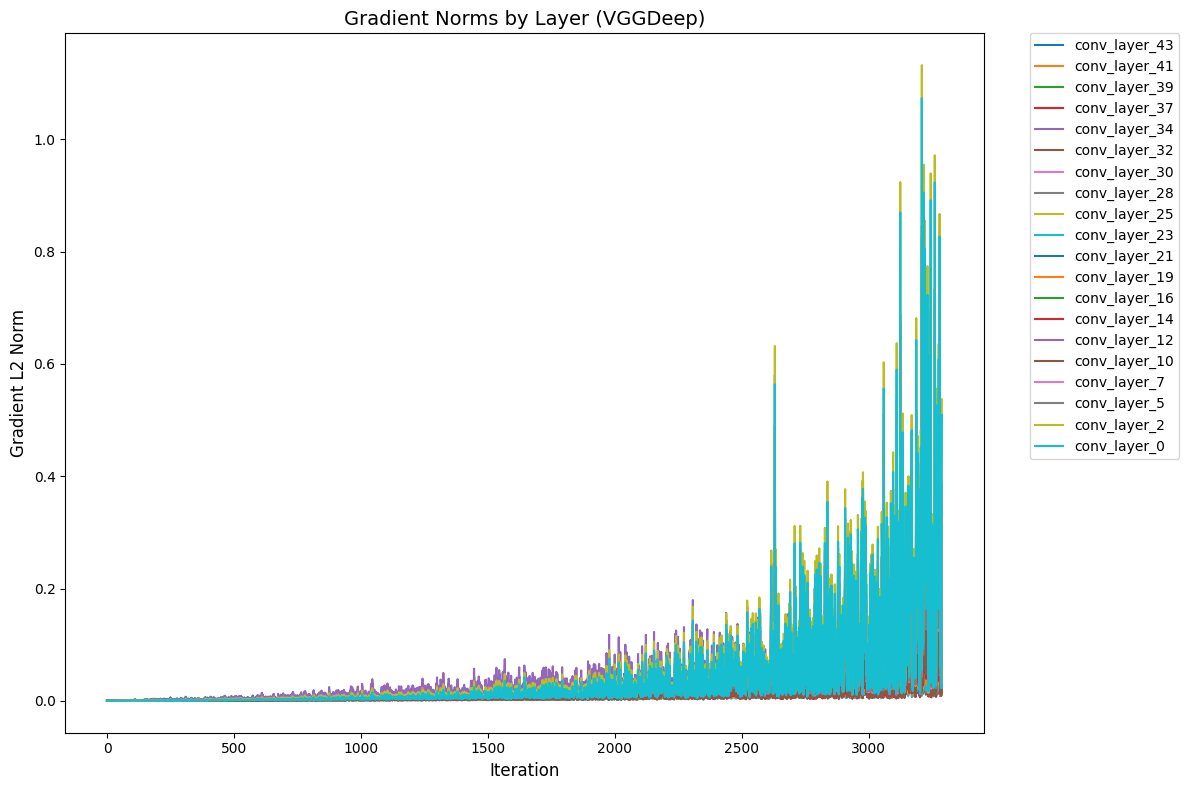

In [ ]:

plt.figure(figsize=(12, 8))

for layer_name, norms in grad_norms.items():
    plt.plot(norms, label=layer_name)

plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Gradient L2 Norm", fontsize=12)
plt.title("Gradient Norms by Layer (VGGDeep)", fontsize=14)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.05, 1.0),
    borderaxespad=0.,
    fontsize=10
)

plt.tight_layout()
plt.show()


- Create a separate plot showing the gradient norms for a subset of layers.

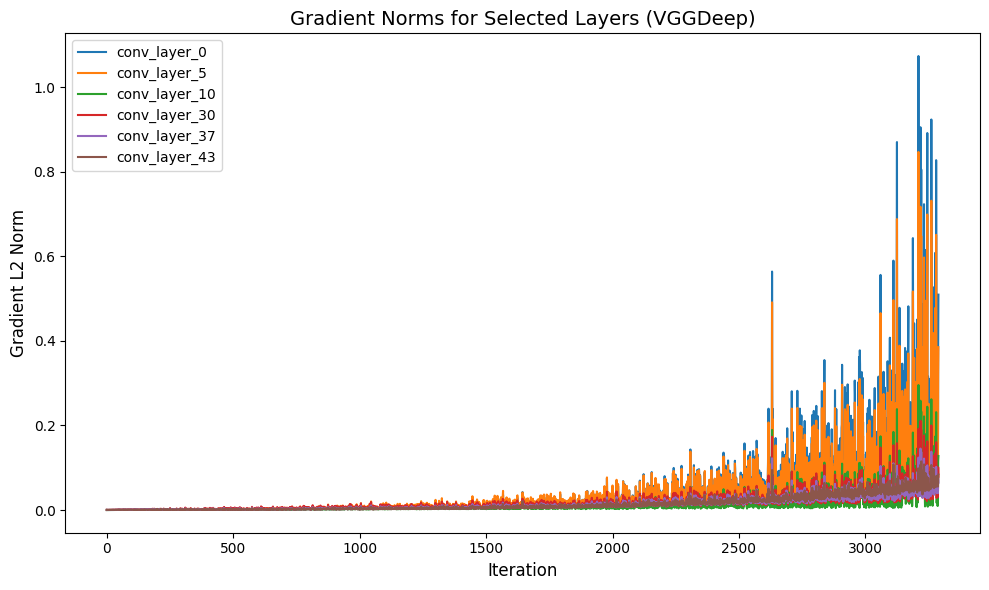

In [ ]:

layers_of_interest = [
    "conv_layer_0",
    "conv_layer_5",
    "conv_layer_10",
    "conv_layer_30",
    "conv_layer_37",
    "conv_layer_43"
]

plt.figure(figsize=(10, 6))

for layer_name in layers_of_interest:
    if layer_name in grad_norms:
        plt.plot(grad_norms[layer_name], label=layer_name)
    else:
        print(f"Warning: {layer_name} not found in grad_norms.")

plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Gradient L2 Norm", fontsize=12)
plt.title("Gradient Norms for Selected Layers (VGGDeep)", fontsize=14)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


<span style='color:green'>Gradient Norms by layer (VGGDeep) graphs shows a the plot where each colored line corresponds to one convolutional layer in VggDeep model, the X axis is the training iteration and the y axis is the L2 norm of the gradients for that layer's weights.       
</span>
<span style='color:green'>In the graph we can see one dominant curve with values reaching from 8 to 10. The layers other gradients are significantly larger than the rest. It suggests that some layers recieves much bigger updates . In a deep VGG-like model without skip connections like in resnet , it indicates vanishing gradients for those quiet layers.               
</span>
<span style='color:green'>In Gradient norms for selected layers(VGGDeep) plot a subset of layers is plotted , this allows us to see how gradient norms evolve in early ,middle and deep layers.              
</span>
Both suggest that most layers in VGGDeep suffers from Vanishing gradients.              
</span>

## Step 4: Comparison with VGG-16 and ResNet-18

Our Resnet Model :

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Residual connection
        out = F.relu(out, inplace=True)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 2, stride=1)   # conv2_x
        self.layer2 = self.make_layer(128, 2, stride=2)  # conv3_x
        self.layer3 = self.make_layer(256, 2, stride=2)  # conv4_x
        self.layer4 = self.make_layer(512, 2, stride=2)  # conv5_x

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),nn.BatchNorm2d(out_channels))

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # conv2_x
        x = self.layer2(x)  # conv3_x
        x = self.layer3(x)  # conv4_x
        x = self.layer4(x)  # conv5_x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def experiment_for_resnet(num_classes, optimizer_name='SGD', batch_size = 32, num_epochs=10):
    print(f"\n--- ResNet18 with optimizer = {optimizer_name}, batch_size = {batch_size} ---")

    model = ResNet18(num_classes=num_classes).to(device)
    optimizer = optimizers[optimizer_name](model.parameters())
    scheduler = StepLR(optimizer, step_size = 5, gamma = 0.5)
    model, history = train_model(model, train_loader, val_loader, optimizer, scheduler=scheduler, num_epochs=num_epochs, patience=3)
    test_loss, test_acc = validate(model, test_loader, nn.CrossEntropyLoss())

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return model, history

model6, history6 = experiment_for_resnet(num_classes=num_classes, optimizer_name = 'SGD', batch_size = 64, num_epochs = 10)

torch.save(model6.state_dict(), "resnet18_best_weights.pth")
print("Model saved successfully!")



--- ResNet18 with optimizer = SGD, batch_size = 64 ---
Epoch [1 of 10]: Train Loss: 0.4386, Train Acc: 0.8243 | Val Loss: 0.9142, Val Acc: 0.6511
Epoch [2 of 10]: Train Loss: 0.2860, Train Acc: 0.8911 | Val Loss: 0.3392, Val Acc: 0.8729
Epoch [3 of 10]: Train Loss: 0.2270, Train Acc: 0.9145 | Val Loss: 0.4654, Val Acc: 0.8480
Epoch [4 of 10]: Train Loss: 0.1866, Train Acc: 0.9304 | Val Loss: 0.3243, Val Acc: 0.8842
Epoch [5 of 10]: Train Loss: 0.1298, Train Acc: 0.9510 | Val Loss: 0.3749, Val Acc: 0.8938
Epoch [6 of 10]: Train Loss: 0.0510, Train Acc: 0.9830 | Val Loss: 0.2700, Val Acc: 0.9196
Epoch [7 of 10]: Train Loss: 0.0276, Train Acc: 0.9915 | Val Loss: 0.3471, Val Acc: 0.9027
Epoch [8 of 10]: Train Loss: 0.0119, Train Acc: 0.9972 | Val Loss: 0.3765, Val Acc: 0.9073
Epoch [9 of 10]: Train Loss: 0.0075, Train Acc: 0.9983 | Val Loss: 0.4747, Val Acc: 0.8916
Early stopping
Test Loss: 0.4876, Test Accuracy: 0.8847
Model saved successfully!


Running our VGG-16 model

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.argmax(dim=1).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, optimizer, scheduler = None, num_epochs = 10, patience = 3):
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        if scheduler is not None:
            scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch + 1} of {num_epochs}]: " f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model, history


def experiment(num_classes, init_type='xavier', optimizer_name='SGD', batch_size=32, num_epochs=10):
    print(f"\n--- VGG16-C with init = {init_type}, optimizer = {optimizer_name}, batch_size = {batch_size} ---")

    model = VGG16C(num_classes=num_classes, init_type=init_type).to(device)
    optimizer = optimizers[optimizer_name](model.parameters())
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    model, history = train_model(model, train_loader, val_loader, optimizer, scheduler=scheduler, num_epochs=num_epochs, patience=3)
    test_loss, test_acc = validate(model, test_loader, nn.CrossEntropyLoss())

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return model, history


model1, history1 = experiment(num_classes=num_classes, init_type='he', optimizer_name = 'SGD', batch_size = 64, num_epochs = 10)



--- VGG16-C with init = he, optimizer = SGD, batch_size = 64 ---
Epoch [1 of 10]: Train Loss: 0.7458, Train Acc: 0.6642 | Val Loss: 0.6105, Val Acc: 0.7593
Epoch [2 of 10]: Train Loss: 0.4559, Train Acc: 0.8217 | Val Loss: 0.4443, Val Acc: 0.8107
Epoch [3 of 10]: Train Loss: 0.4015, Train Acc: 0.8441 | Val Loss: 0.3481, Val Acc: 0.8629
Epoch [4 of 10]: Train Loss: 0.3523, Train Acc: 0.8650 | Val Loss: 0.3361, Val Acc: 0.8773
Epoch [5 of 10]: Train Loss: 0.3234, Train Acc: 0.8782 | Val Loss: 0.4083, Val Acc: 0.8409
Epoch [6 of 10]: Train Loss: 0.2796, Train Acc: 0.8953 | Val Loss: 0.2848, Val Acc: 0.8924
Epoch [7 of 10]: Train Loss: 0.2455, Train Acc: 0.9070 | Val Loss: 0.3150, Val Acc: 0.8898
Epoch [8 of 10]: Train Loss: 0.2338, Train Acc: 0.9119 | Val Loss: 0.2570, Val Acc: 0.9056
Epoch [9 of 10]: Train Loss: 0.2193, Train Acc: 0.9177 | Val Loss: 0.2418, Val Acc: 0.9158
Epoch [10 of 10]: Train Loss: 0.2146, Train Acc: 0.9213 | Val Loss: 0.2538, Val Acc: 0.9078
Test Loss: 0.2348, Test

- Compare the training curves (loss and accuracy vs. epoch) of VGG-Deep, VGG-16, and ResNet-18.

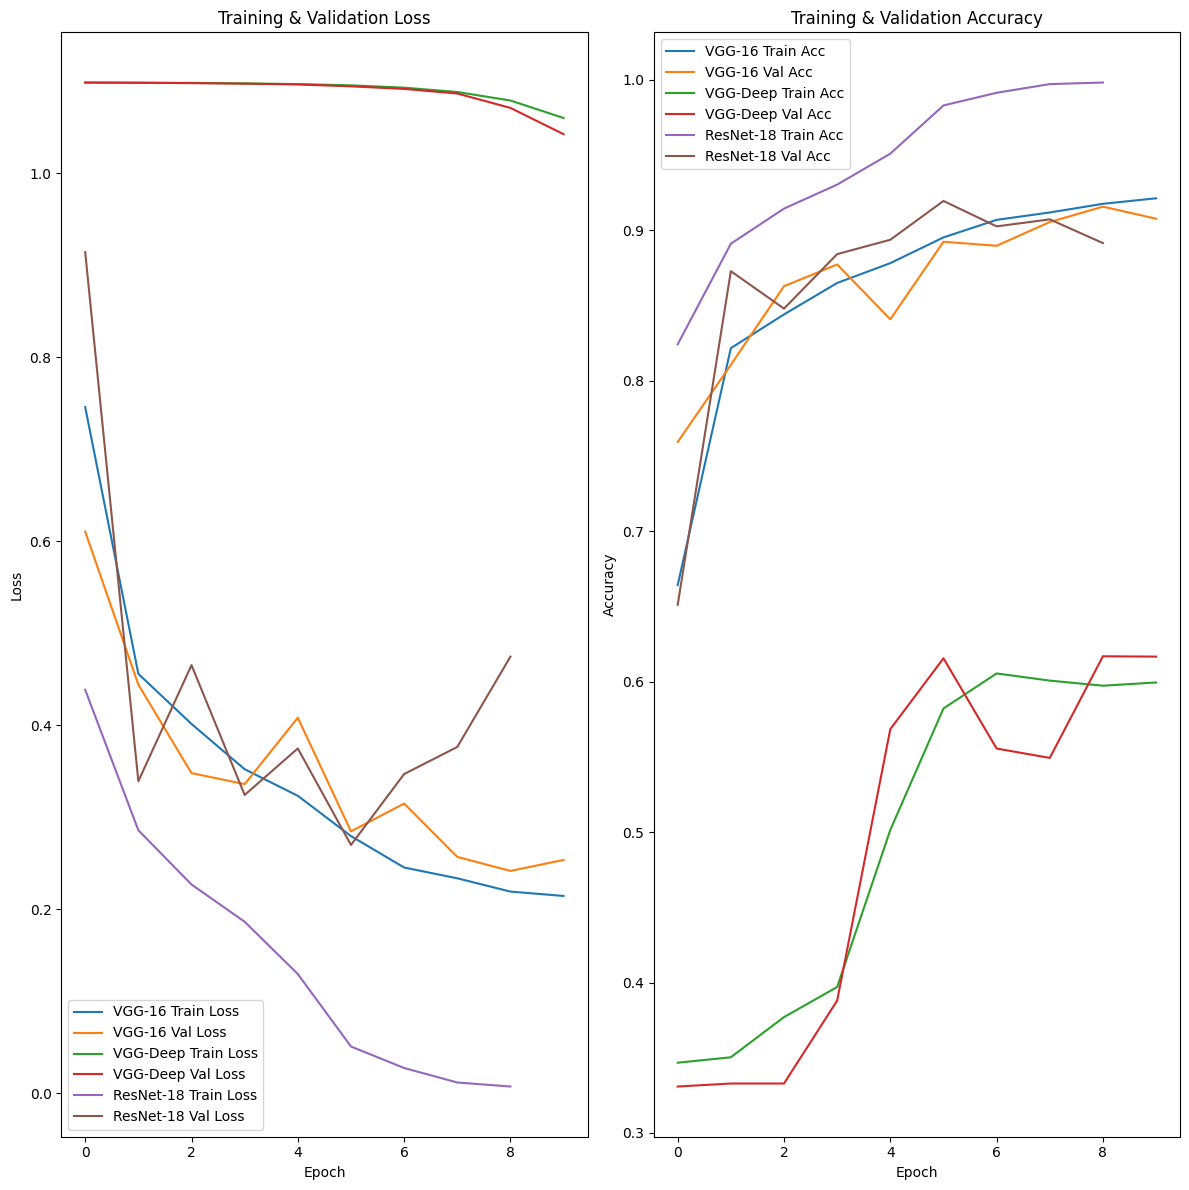

In [ ]:

def plot_training_curves(hist_vgg16, hist_vggdeep, hist_resnet):
    """
    Plots training & validation loss and accuracy for three models:
      - VGG-16
      - VGG-Deep
      - ResNet-18
    """

    plt.figure(figsize=(12, 12))

    # 1) Loss Curves
    plt.subplot(1, 2, 1)
    # VGG-16
    plt.plot(history1['train_loss'], label='VGG-16 Train Loss')
    plt.plot(history1['val_loss'],   label='VGG-16 Val Loss')
    # VGG-Deep
    plt.plot(hist_vggdeep['train_loss'], label='VGG-Deep Train Loss')
    plt.plot(hist_vggdeep['val_loss'],   label='VGG-Deep Val Loss')
    # ResNet-18
    plt.plot(hist_resnet['train_loss'], label='ResNet-18 Train Loss')
    plt.plot(hist_resnet['val_loss'],   label='ResNet-18 Val Loss')

    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 2) Accuracy Curves
    plt.subplot(1, 2, 2)
    # VGG-16
    plt.plot(hist_vgg16['train_acc'], label='VGG-16 Train Acc')
    plt.plot(hist_vgg16['val_acc'],   label='VGG-16 Val Acc')
    # VGG-Deep
    plt.plot(history_deep['train_acc'], label='VGG-Deep Train Acc')
    plt.plot(history_deep['val_acc'],   label='VGG-Deep Val Acc')
    # ResNet-18
    plt.plot(history6['train_acc'], label='ResNet-18 Train Acc')
    plt.plot(history6['val_acc'],   label='ResNet-18 Val Acc')

    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history1, history_deep, history6)

- Discuss how ResNet’s residual connections impact the gradient flow compared to VGG-Deep.

Residual connections in Resnet provide shortcuts for gradients to flow directly from the loss to earlier layers. But in VGGDeep being very deep but without skip connections forces the gradients to pass sequentially through many layers making them vanish at each step .

Looking at the above graph(Training and Validation loss curve ): For the curve of Resnet18, We can see there is a rapid drop toward lower loss compared to VGGDeep curve , reflecting a healthier gradient flow , the skips connections ensure each block still recieves a strong signal from the final layers.

Looking at the above graph(Training vs Validation accuracy curve): The accuracy curve for Resnet-18 quickly overtakes both VGGDeep and VGG16 , approaching close to 99 percent in some of our experiments. VGGDeep is volatile , with a lower final accuracy or sudden spike indicating that the model is struggling with gradient updates.


Skip connections helps because each residual block computes output= F(input) + input . Even if F(.) dampens gradients , adding input directly to the output preserves a undiminished portion of the gradient. This effect prevents the pinning of small gradients in very deep networks like VGGDeep.


<span style='color:green'></span>

## Step 5: Investigate and analyze more setups

- Select any THREE experiments to investigate and analyze.

### Experiment 1 : Impact of kernel size

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class SmallVGG(nn.Module):
    def __init__(self, num_classes=3, kernel_size=3):
        super(SmallVGG, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.flatten_size = self.get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 96, 96)
            output = self.features(dummy_input)
            return output.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Using device: cuda


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.argmax(dim=1).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1).long()

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}]: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, history


In [ ]:
indices = list(range(len(dataset)))
subset_indices, _ = train_test_split(
    indices,
    train_size=1000 * num_classes,
    stratify=[dataset[i][1] for i in indices],
    random_state=42
)

train_subset = Subset(dataset, subset_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(train_subset, batch_size=64, shuffle=False, num_workers=4)

#different kernel sizes
kernel_sizes = [3, 5, 7]
results = {}

for kernel in kernel_sizes:
    print(f"\nTraining Small VGG with Kernel Size {kernel}x{kernel}")

    model = SmallVGG(kernel_size=kernel).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model, history = train_model(model, train_loader, val_loader, optimizer, num_epochs=10)
    results[kernel] = history

def plot_training_curves(results):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    for kernel, hist in results.items():
        plt.plot(hist['train_loss'], label=f'Kernel {kernel}x{kernel} Train Loss')
        plt.plot(hist['val_loss'], linestyle='dashed', label=f'Kernel {kernel}x{kernel} Val Loss')

    plt.title("Training & Validation Loss (Different Kernel Sizes)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for kernel, hist in results.items():
        plt.plot(hist['train_acc'], label=f'Kernel {kernel}x{kernel} Train Acc')
        plt.plot(hist['val_acc'], linestyle='dashed', label=f'Kernel {kernel}x{kernel} Val Acc')

    plt.title("Training & Validation Accuracy (Different Kernel Sizes)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()



Training Small VGG with Kernel Size 3x3
Epoch [1/10]: Train Loss: 0.7946, Train Acc: 0.6310 | Val Loss: 0.5602, Val Acc: 0.7653
Epoch [2/10]: Train Loss: 0.5283, Train Acc: 0.7920 | Val Loss: 0.4338, Val Acc: 0.8280
Epoch [3/10]: Train Loss: 0.4460, Train Acc: 0.8240 | Val Loss: 0.4165, Val Acc: 0.8270
Epoch [4/10]: Train Loss: 0.4133, Train Acc: 0.8340 | Val Loss: 0.3129, Val Acc: 0.8717
Epoch [5/10]: Train Loss: 0.3073, Train Acc: 0.8790 | Val Loss: 0.2492, Val Acc: 0.9047
Epoch [6/10]: Train Loss: 0.2549, Train Acc: 0.9000 | Val Loss: 0.2731, Val Acc: 0.8820
Epoch [7/10]: Train Loss: 0.1921, Train Acc: 0.9233 | Val Loss: 0.1591, Val Acc: 0.9423
Epoch [8/10]: Train Loss: 0.1465, Train Acc: 0.9460 | Val Loss: 0.1187, Val Acc: 0.9537
Epoch [9/10]: Train Loss: 0.0896, Train Acc: 0.9690 | Val Loss: 0.0448, Val Acc: 0.9863
Epoch [10/10]: Train Loss: 0.0788, Train Acc: 0.9727 | Val Loss: 0.0432, Val Acc: 0.9887

Training Small VGG with Kernel Size 5x5
Epoch [1/10]: Train Loss: 0.8742, Tra

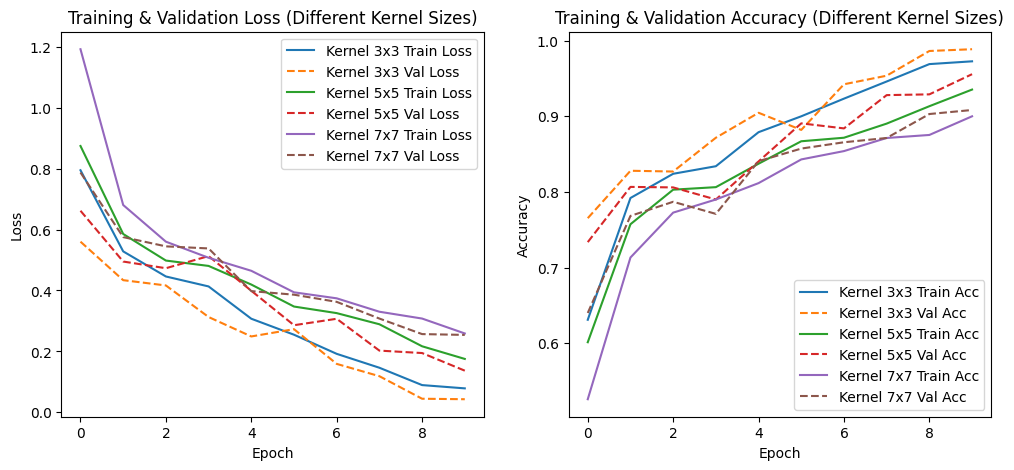

In [ ]:
plot_training_curves(results)

3*3 kernel : faster convergence , highesht final accuracy
5*5 kernel : slightly slower convergence but eventually reaches 95.6% on validation.
7*7 : Potentially ebeficial for bigger objects but can be slower and parameter heavy , ends with 90.8% validation accuracy

### Experiment 2 : 1x1 Convolutions

In [ ]:
class SmallCNNWith1x1(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNNWith1x1, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, kernel_size=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.flatten_size = self.get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 96, 96)
            output = self.features(dummy_input)
            return output.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class SmallCNNNo1x1(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNNNo1x1, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten_size = self.get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 96, 96)
            output = self.features(dummy_input)
            return output.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
from torchsummary import summary

model_1x1 = SmallCNNWith1x1(num_classes=3)
summary(model_1x1, (3, 96, 96), device='cpu')

model_no1x1 = SmallCNNNo1x1(num_classes=3)
summary(model_no1x1, (3, 96, 96), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          18,496
              ReLU-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 32, 96, 96]           2,080
              ReLU-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Linear-8                  [-1, 128]       9,437,312
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 3]             387
Total params: 9,459,171
Trainable params: 9,459,171
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 18.56
Params size (MB): 36.08
Estim

In [ ]:
model_1x1 = SmallCNNWith1x1(num_classes=3).to(device)
optimizer_1x1 = optim.Adam(model_1x1.parameters(), lr=0.001)
print("\nTraining 1*1 Model")
model_1x1, history_1x1 = train_model(model_1x1, train_loader, val_loader, optimizer_1x1, num_epochs=10)

model_no1x1 = SmallCNNNo1x1(num_classes=3).to(device)
optimizer_no1x1 = optim.Adam(model_no1x1.parameters(), lr=0.001)
print("\nTraining No 1*1  Model")
model_no1x1, history_no1x1 = train_model(model_no1x1, train_loader, val_loader, optimizer_no1x1, num_epochs=10)


Training 1*1 Model
Epoch [1/10]: Train Loss: 0.9348, Train Acc: 0.6033 | Val Loss: 0.6447, Val Acc: 0.7083
Epoch [2/10]: Train Loss: 0.6308, Train Acc: 0.7203 | Val Loss: 0.5322, Val Acc: 0.7700
Epoch [3/10]: Train Loss: 0.5648, Train Acc: 0.7557 | Val Loss: 0.5003, Val Acc: 0.7897
Epoch [4/10]: Train Loss: 0.4908, Train Acc: 0.7990 | Val Loss: 0.4072, Val Acc: 0.8410
Epoch [5/10]: Train Loss: 0.3846, Train Acc: 0.8433 | Val Loss: 0.2900, Val Acc: 0.8927
Epoch [6/10]: Train Loss: 0.2833, Train Acc: 0.8907 | Val Loss: 0.2548, Val Acc: 0.9017
Epoch [7/10]: Train Loss: 0.2278, Train Acc: 0.9140 | Val Loss: 0.2431, Val Acc: 0.9017
Epoch [8/10]: Train Loss: 0.1570, Train Acc: 0.9443 | Val Loss: 0.0845, Val Acc: 0.9770
Epoch [9/10]: Train Loss: 0.0783, Train Acc: 0.9787 | Val Loss: 0.0546, Val Acc: 0.9890
Epoch [10/10]: Train Loss: 0.0373, Train Acc: 0.9937 | Val Loss: 0.0237, Val Acc: 0.9983

Training No 1*1  Model
Epoch [1/10]: Train Loss: 1.2035, Train Acc: 0.5863 | Val Loss: 0.6362, Val

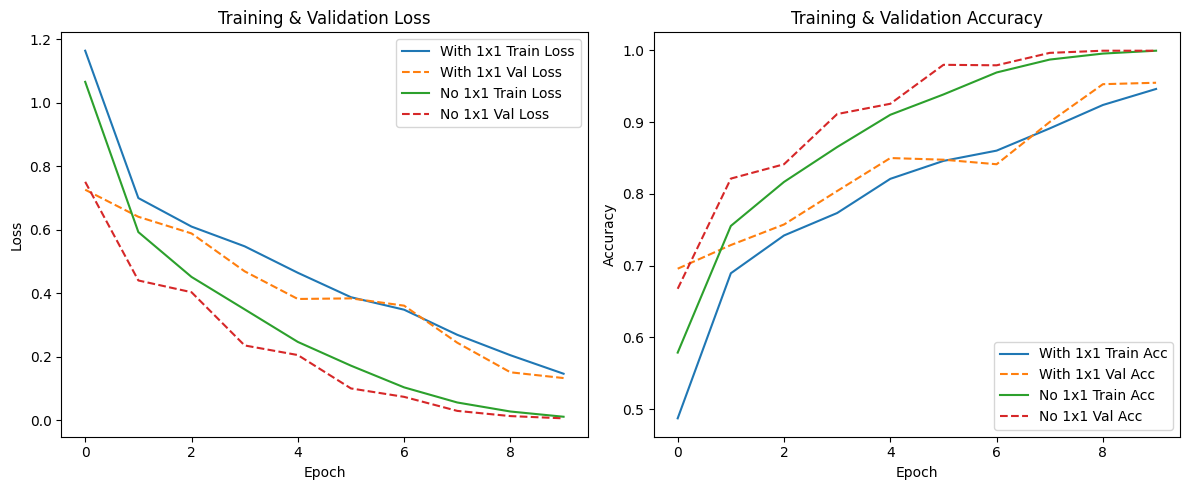

In [ ]:
def plot_compare_histories(hist_a, hist_b, label_a="With 1x1", label_b="No 1x1"):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(hist_a['train_loss'], label=f'{label_a} Train Loss')
    plt.plot(hist_a['val_loss'], linestyle='--', label=f'{label_a} Val Loss')
    plt.plot(hist_b['train_loss'], label=f'{label_b} Train Loss')
    plt.plot(hist_b['val_loss'], linestyle='--', label=f'{label_b} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(hist_a['train_acc'], label=f'{label_a} Train Acc')
    plt.plot(hist_a['val_acc'], linestyle='--', label=f'{label_a} Val Acc')
    plt.plot(hist_b['train_acc'], label=f'{label_b} Train Acc')
    plt.plot(hist_b['val_acc'], linestyle='--', label=f'{label_b} Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_compare_histories(history_1x1, history_no1x1, "With 1x1", "No 1x1")

Model with 1*1 , final validation accuracy is around 99.8 , training accuracy is 99.37, slightly fewer parameters but still achieving very high performance.

Model with noo 1*1 : Ends near 100 percent training accuracy and 100 percent validation accuracy in some epochs . Even higher capacity that it cannot almost memorize the dataset if its not too large .


### Experiment 3 : Max Pooling vs. Average Pooling.

In [ ]:
class SmallVGGPooling(nn.Module):
    def __init__(self, pooling_type='max', num_classes=3):
        super(SmallVGGPooling, self).__init__()

        if pooling_type.lower() == 'max':
            pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pooling_type.lower() == 'avg':
            pool_layer = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            raise ValueError("pooling_type must be 'max' or 'avg'.")

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool_layer,

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool_layer,
        )

        self.flatten_size = self.get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

    def get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 96, 96)
            output = self.features(dummy_input)
            return output.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.argmax(dim=1).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1).long()

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}]: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, history


Using device: cuda


In [ ]:
num_classes = 3
indices = list(range(len(dataset)))
subset_indices, _ = train_test_split(
    indices,
    train_size=1000 * num_classes,
    stratify=[dataset[i][1] for i in indices],
    random_state=42
)

train_subset = Subset(dataset, subset_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(train_subset, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
model_max = SmallVGGPooling(pooling_type='max', num_classes=3).to(device)
optimizer_max = optim.Adam(model_max.parameters(), lr=0.001)

print("\nTraining Model with Max Pooling")
model_max, history_max = train_model(model_max, train_loader, val_loader, optimizer_max, num_epochs=10)

model_avg = SmallVGGPooling(pooling_type='avg', num_classes=3).to(device)
optimizer_avg = optim.Adam(model_avg.parameters(), lr=0.001)

print("\nTraining Model with Average Pooling")
model_avg, history_avg = train_model(model_avg, train_loader, val_loader, optimizer_avg, num_epochs=10)



Training Model with Max Pooling
Epoch [1/10]: Train Loss: 0.7345, Train Acc: 0.6807 | Val Loss: 0.5301, Val Acc: 0.7803
Epoch [2/10]: Train Loss: 0.5038, Train Acc: 0.8020 | Val Loss: 0.4794, Val Acc: 0.8093
Epoch [3/10]: Train Loss: 0.4269, Train Acc: 0.8253 | Val Loss: 0.3534, Val Acc: 0.8663
Epoch [4/10]: Train Loss: 0.3584, Train Acc: 0.8567 | Val Loss: 0.2809, Val Acc: 0.8960
Epoch [5/10]: Train Loss: 0.2927, Train Acc: 0.8873 | Val Loss: 0.2655, Val Acc: 0.9063
Epoch [6/10]: Train Loss: 0.2343, Train Acc: 0.9157 | Val Loss: 0.1690, Val Acc: 0.9483
Epoch [7/10]: Train Loss: 0.1649, Train Acc: 0.9427 | Val Loss: 0.1134, Val Acc: 0.9647
Epoch [8/10]: Train Loss: 0.1072, Train Acc: 0.9650 | Val Loss: 0.0570, Val Acc: 0.9897
Epoch [9/10]: Train Loss: 0.0802, Train Acc: 0.9740 | Val Loss: 0.0742, Val Acc: 0.9813
Epoch [10/10]: Train Loss: 0.0532, Train Acc: 0.9873 | Val Loss: 0.0803, Val Acc: 0.9703

Training Model with Average Pooling
Epoch [1/10]: Train Loss: 0.8410, Train Acc: 0.60

For Max Pooling : We get faster convergence , at epoch 5 the accuracy is already at 90.63 . RObust feature detection : max pooling often helps classification tasks focus on key features regardless of their small shifts .

For Average Pooling : Slightly lower training accuracy , a marginally higher final validation accuracy. Average pooling blends activation accuracy , preserving more overall distribution .

## Step 6: Analysis and discussion

a. Analyze your gradient norm plots. Do they demonstrate the vanishing gradient problem? Explain how the gradient norm changes as you move deeper into VGG-Deep. Be specific and quantitative (e.g., "The gradient norm of layer 2 is X times larger than the gradient norm of layer 10").

Gradient Norms by layer (VGGDeep) graphs shows a the plot where each colored line corresponds to one convolutional layer in VggDeep model, the X axis is the training iteration and the y axis is the L2 norm of the gradients for that layer's weights.
In the graph we can see one dominant curve with values reaching from 8 to 10. The layers other gradients are significantly larger than the rest. It suggests that some layers recieves much bigger updates . In a deep VGG-like model without skip connections like in resnet , it indicates vanishing gradients for those quiet layers.
In Gradient norms for selected layers in VGGDeep plot a subset of layers is plotted , this allows us to see how gradient norms evolve in early ,middle and deep layers.
Both suggest that most layers in VGGDeep suffers from Vanishing gradients.If gradients at the input-side layers (like layer 43) are two orders of magnitude smaller than those near the output (like layer 0), then updates to those deeper layers are minuscule in comparison.
Over many iterations, these “starved” layers barely change, while a few layers with large gradients do most of the learning—one hallmark of vanishing gradients.Around iteration 3000,
conv_layer_0
conv_layer_0 peaks near 1.1 in L2 norm, whereas
conv_layer_37
conv_layer_37 or
conv_layer_43
conv_layer_43 might hover around 0.01-0.03. That’s a 30-100x difference in gradient magnitude. For iterations less than 1000 : All gradients are relatively small but still the difference between the biggest and the smallest is noticeable , maybe 3-5 x bigger .
For mid to later iterations :  The gap widens drastically , layer 0 climbs above 1.0 l2 norm , layer 5 approaches 0.8 - 1.0 , but layer 42 remains near 0.02 to 0.05.

Therfore based on the plots , we can show that the VGGDeep model is demonstrating Vanish Gradient effect.

b. Explain why the vanishing gradient problem occurs in deep networks. Relate this to the backpropagation algorithm and the chain rule. Discuss how the repeated multiplication of small gradients can lead to extremely small values in earlier layers.

When we train a really deep neural network, we want to update the weights in the first layers just as effectively as the last layers.But, when we use the backpropagation algorithm, each update in an early layer is found by multiplying many small numbers that come from each subsequent layer. If any of those numbers are even slightly below 1, multiplying them over and over makes the final product very small. This is called the vanishing gradient problem. In practical terms, it means that the weights near the beginning of the network barely change at all, because the gradient arriving from the output layer is almost zero by the time it gets back to them.


Backpropagation works by applying the chain rule. We compute the gradient of the loss with respect to each intermediate output, step by step, moving from the final layer back to first. Each step in that chain can have a derivative that is less than 1 in magnitude especially if we are using activation functions like sigmoid or tan h. Multiplying these together and the product gets tinier and the further we go toward the first layer. Thats why we say the gradient vanishes,early weights wnt really get the necessary updates to learn effectively.


In a shallower network, we dont multiply as many small numbers, so this shrinking effect isnt as severe. But in a deep architecture, it can become a big obstacle unless we do something to keep gradients getting so small. Techniques like residual connections or certain normalization methods help ensure the gradient doesnt keep shrinking at every single layer, which alleviates the vanishing gradient problem.


c. Explain how ResNet's architecture (residual connections) helps alleviate the vanishing gradient problem. Explain how the identity mapping allows gradients to flow more easily through the network.

Resnet addresses the vanishing gradient problem by allowing part of the network's output to skip certain layers . Instead of computing f(x) , a resnet layer outputs x + f(x) . The x part is called identity mapping , it provides a direct path for the gradient to travel backward without being multiplied by all the small derivatives in those layers .
In a normal deep neural net, the gradient has to pass through each layer's calculations and if any layers derivative is small , it starts to shrink the gradient. Over many layers , this repeated shrinking can make the gradient nearly zero by the time it gets to first layer. In Resnet , at every layer the gradient can also flow through that skip route , where it doesnt get diminished by the layers derivative. As a result , earlier layers still recieve enough gradient to update effectively , so that network can ve built without suffering as much from vanishing gradients.

d. Discuss the theoretical impact of batch normalization on the vanishing/exploding gradient problem. Explain how it helps stabilize and accelerate training.

Batch normalization helps prevent gradients from vanihsing or exploding by normalizing the activations inside the network. Normally when we move through many layers , even small changes in weights can lead to large changes in the distribution of activations , which leads to the network output to shift around unpredictably . When this happens , gradients can either explore or vanish.
Batch normalisation tackles this by taking each batch and recenter and rescaling activations for each channel. it forces activations to have a more stable mean and variance layer by layer. Because these activations stay within a healthier numeric range , the derivatives also tend to stay in a moderate zone rather than exploding or vanishing.

This makes training faster and more stable: the network doesnt have to constantly adjust to wild swings in activation distributions so it can keep learning without getting stuck or blowing up. It often allows to use higher learning rates, since the normalized activations are less likely to cause huge parameter updates. This combination of stable activations and smoother gradients is why batch normalization usually leads to better , more reliable convergence in deep networks.

e. Summarize the key findings from your three chosen investigations.

Experiment 1 : Impact of Kernel Size :    
3 * 3 kernel : faster convergence , highesht final accuracy
5 * 5 kernel : slightly slower convergence but eventually reaches 95.6% on validation.
7 * 7 : Potentially ebeficial for bigger objects but can be slower and parameter heavy , ends with 90.8% validation accuracy.
Loss curves : 3 * 3 drop quickly and stabilise at a lower level. 5 * 5 is in the middle but fairly strong .
7 * 7 starts higher and remains somewhat above the others.
Impact on receptive field and feature capture :    
3 * 3 kernels : Small local filters capturing edges, corners, small textures.
5 * 5 kernels : Provides a wider local field in one convolution.Mostly helpful if features are more spread out or large.More parameters and computationaly expensive than 3 * 3 .
7 * 7 : Very large receptive field immediately. Might be beneficial for bigger input sizes.
Recommendations :    
best : The 3 * 3 model achieved the highest final accuracy


Experiement 2 : 1 * 1 convolutions vs no 1 * 1 convolutions
Purpose and benefits of 1 * 1 convolutions : Dimension Reduction : A 1 * 1 kernel can reduce the number of channels. By reducing channel depth before fully connected layers ,we cut down the total number of parameters .
Feature Recombination : 1 * 1 convolution can considered as linear combination across channels at every spatial location
Parameter Count comparison : With 1 * 1: total parameters are around 9.46 billion, since we replaced a 64 channel conv with 1 * 1 that lowers channels to 32 .
With no 1 * 1 : total parameters are around 18.89 billion, the final featyure map remains 64 channels.
Performance :
Model with 1*1 , final validation accuracy is around 99.8 , training accuracy is 99.37, slightly fewer parameters but still achieving very high performance.

Model with noo 1*1 : Ends near 100 percent training accuracy and 100 percent validation accuracy in some epochs . Even higher capacity that it cannot almost memorize the dataset if its not too large .
Tradeoffs : With 1 * 1 : Fewer parameters: faster inference, less memory usage.
Still capable of near 99%+ accuracy.
beneficial if resources are limited .
with no 1 * 1 : More Parameters , potentially overfitting , if we need top accuracy we can use .

Experiment 3 : Max Pooling vs Average Pooling
Performance : For Max Pooling : We get faster convergence , at epoch 5 the accuracy is already at 90.63 . RObust feature detection : max pooling often helps classification tasks focus on key features regardless of their small shifts .

For Average Pooling : Slightly lower training accuracy , a marginally higher final validation accuracy. Average pooling blends activation accuracy , preserving more overall distribution .

When to prefer which ? : Max pooling is commonly used in classification , picks out the strongest feature in a patch , robust . Cons : Potentially discards subtle information since it only keeps maximum activation.

Average pooling is helpful in tasks where global spatial information is more critical.Preserves an overall sense of the local distribution .Cons : Moree sensitive to small distortions .



f. References. Include details on all the resources used to complete this part.

VGG wikipedia

DeepLearning Ai for understanding Vanishing gradients : https://youtu.be/qhXZsFVxGKo?si=izGQXiXHrysF1k03

Resnet understanding :   https://youtu.be/Q1JCrG1bJ-A?si=ZjdFbBqDuCnLD0ec


